## Requirements: numpy, matplotlib, bin2py, visionloader, os, sta_utils

In [21]:
import numpy as np
import matplotlib.pyplot as plt
import bin2py
import visionloader as vl
import os
import sta_utils as su
from matplotlib.patches import Ellipse
import importlib as il
il.reload(su);

## Set up data paths as arguments: need raw data path, analysis path, and datarun name.

In [22]:
# Constants.
PARENT_ANALYSIS = '/Volumes/Analysis/' # Where analysis lives.
PARENT_DATA = '/Volumes/Data/' # Where data lives.

# Look at some 60-micron peripheral data set.
dataset = '2019-08-27-3'
datarun = 'data000'

# Set paths.
analysis_path = os.path.join(PARENT_ANALYSIS,dataset,datarun)
raw_data_path = os.path.join(PARENT_DATA,dataset,datarun)

## Load in vision data, and initialize raw file reader object.

In [23]:
# Get Vision container with various things.
vision_data = vl.load_vision_data(analysis_path,
                                  datarun,
                                  include_params=True,
                                  include_ei=True,
                                  include_sta=True, 
                                  include_runtimemovie_params=True,
                                  include_neurons=True,
                                  include_noise=True)

## Let's first plot a cell's EI: cell ID 4487 looks good.

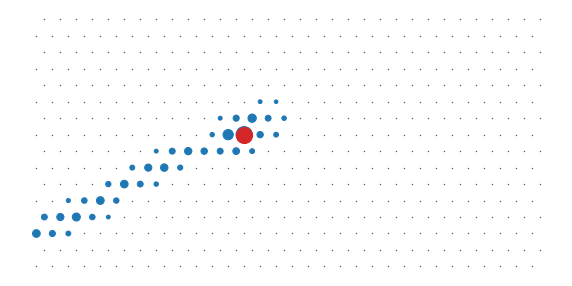

In [24]:
# Constants.
NUM_SIGMAS = .5 # Kind of low, but at least it's noise-based.
SIZE_SCALAR = 5 

# Get the cellids, and get the cell of interests' EI.
cell = 4487
cellids = sorted(vision_data.get_cell_ids())
assert cell in cellids
cell_ei = vision_data.get_ei_for_cell(cell).ei

# Get the electrode map to plot on the array.
electrode_map = vision_data.electrode_map
xcoords = electrode_map[:,0]
ycoords = electrode_map[:,1]
num_channels = electrode_map.shape[0]

# Get the largest spike amplitude across each channel, and get significant channels.
ei = np.amax(np.abs(cell_ei),axis=1)
noise = vision_data.channel_noise
sig_channel_inds = np.argwhere(ei > NUM_SIGMAS * noise).flatten()
non_sig_channel_inds = np.argwhere(ei <= NUM_SIGMAS * noise).flatten()
assert np.all(np.union1d(sig_channel_inds,non_sig_channel_inds) == np.arange(0,num_channels))

# Initialize plotting, plot the ei.
fig,ax = plt.subplots(1,1,figsize=(10,5))
ax.scatter(xcoords[non_sig_channel_inds],ycoords[non_sig_channel_inds],
           c='k',s=.1)
ax.scatter(xcoords[sig_channel_inds],ycoords[sig_channel_inds],
           s=ei[sig_channel_inds] * SIZE_SCALAR,
           c='C0')

# Get the seed electrode for this cell, and plot as in Vision.
with vl.NeuronsReader(analysis_path,datarun) as nr:
    seed_elec = nr.get_identifier_electrode_for_neuron(cell)
    seed_elec_ind = seed_elec - 1 # Adjusted for indexing.
    
ax.scatter(xcoords[seed_elec_ind],ycoords[seed_elec_ind],
           s=ei[seed_elec_ind] * SIZE_SCALAR,
           c='C3')
ax.tick_params(axis='x',which='both',bottom=False,top=False,labelbottom=False)
ax.tick_params(axis='y',which='both',left=False,right=False,labelleft=False)
ax.axis('off')
plt.show()

## Now let's plot this cell's STA.

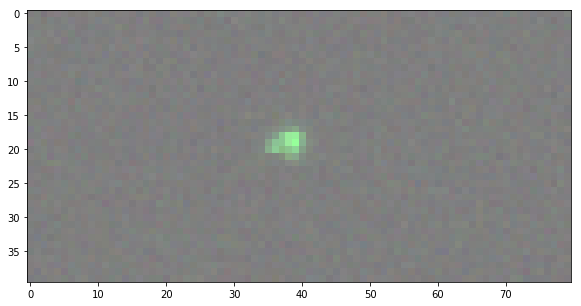

In [25]:
# Retrieve container from object, and get the normalized tensor.
MAX_STA_IND = 26 # From looking in Vision GUI STA plot.
sta_container = vision_data.get_sta_for_cell(cell)
sta_tensor = su.get_sta_tensor(sta_container)
max_sta_frame = sta_tensor[:,:,:,MAX_STA_IND]

fig,ax = plt.subplots(1,1,figsize=(10,5))
ax.imshow(max_sta_frame)
# ax.tick_params(axis='x',which='both',bottom=False,top=False,labelbottom=False)
# ax.tick_params(axis='y',which='both',left=False,right=False,labelleft=False)
# ax.axis('off')

## Let's plot the receptive field mosaics of the ON  and OFF parasols

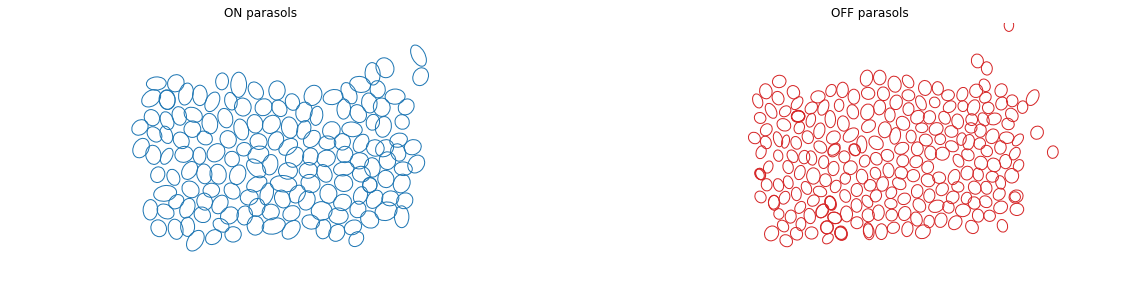

In [26]:
# Constant, from Vision.
NUM_SIGMAS_RFFIT = 2

# Get runtime movie parameters to set plotting limits.
height = int(vision_data.runtimemovie_params.height)
width = int(vision_data.runtimemovie_params.width)

# Initialize plotting, plot ON and OFF parasols.
fig,ax = plt.subplots(1,2,figsize=(20,5))

for cellid in cellids:
    celltype = vision_data.get_cell_type_for_cell(cellid).lower()
    
    if 'on' in celltype and 'parasol' in celltype:
        color = 'C0'
        ind = 0
        title = 'ON parasols'
    elif 'off' in celltype and 'parasol' in celltype:
        color = 'C3'
        ind = 1
        title = 'OFF parasols'
    else: 
        continue
        
    sta_fit = vision_data.get_stafit_for_cell(cellid)

    """
    Some egregious and confusing hacks are necessary to match Vision's RF plots.
    You apparently have to subtract off the height from the mean (y-axis), 
    swap sigma_x and sigma_y, and multiply the tilt in degrees by -1 (at least
    for usage in matplotlib's Ellipse class)
    """ 
    mu_x = sta_fit.center_x
    mu_y = height - sta_fit.center_y
    sigma_x = sta_fit.std_y
    sigma_y = sta_fit.std_x

    # Convert the tilt to degrees, and flip to be consistent with Vision.
    degrees = sta_fit.rot * (180 / np.pi) * -1
    fit = Ellipse(xy = (mu_x,mu_y), width = NUM_SIGMAS_RFFIT * sigma_y,
                  height = NUM_SIGMAS_RFFIT * sigma_x,
                  angle = degrees)
    ax[ind].add_artist(fit)
    fig.set_clip_box(ax[ind])
    fit.set_alpha(1)
    fit.set_facecolor('none')
    fit.set_edgecolor(color)
        
    # Must explicitly set the limits with Ellipse.
    ax[ind].set_xlim([0,width-1])
    ax[ind].set_ylim([0,height-1]) 
    ax[ind].tick_params(axis='x',which='both',bottom=False,top=False,labelbottom=False)
    ax[ind].tick_params(axis='y',which='both',left=False,right=False,labelleft=False)
    ax[ind].axis('off')
    ax[ind].set_title(title)
plt.show()

## Let's plot some raw spikes for the cell of interest.

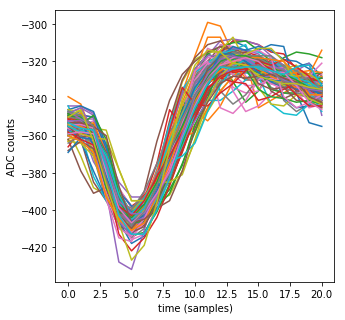

In [27]:
# Constants for getting data snippets.
L_SAMPLES = 5
R_SAMPLES = 15

# Get spike times from cell of interest, and initialize raw data file object.
spike_times_cell = vision_data.get_spike_times_for_cell(cell)

# Initialize raw file object
pbr = bin2py.PyBinFileReader(raw_data_path)

# Make some plots on the seed electrode of the first 100 spikes.
num_spikes = 100
num_samples = L_SAMPLES + R_SAMPLES + 1
plt.figure(figsize=(5,5))

for i in range(num_spikes):
    spike_time = spike_times_cell[i] - L_SAMPLES
    raw_data = pbr.get_data(spike_time,num_samples).T
    
    # This contains the ttl, so can index with true electrode ID.
    plt.plot(raw_data[seed_elec,:])
    plt.xlabel('time (samples)')
    plt.ylabel('ADC counts')
plt.show()